In [2]:
import json


In [3]:
# Load the SDK
%matplotlib inline
from lyft_dataset_sdk.lyftdataset import LyftDataset
dataPath = '/home/itiv/Desktop/lyft-dataset'

# Load the dataset
# Adjust the dataroot parameter below to point to your local dataset path.
# The correct dataset path contains at least the following four folders (or similar): images, lidar, maps, v1.0.1-train
level5data = LyftDataset(data_path=dataPath, json_path=dataPath+'/v1.02-train', verbose=True)

9 category,
18 attribute,
4 visibility,
15991 instance,
8 sensor,
128 calibrated_sensor,
149072 ego_pose,
148 log,
148 scene,
18634 sample,
149072 sample_data,
539765 sample_annotation,
1 map,
Done loading in 5.6 seconds.
Reverse indexing ...
Done reverse indexing in 1.8 seconds.


In [4]:
#choose scene
detections = ''

#my_scene = level5data.scene[17]
#my_scene_token = my_scene['token']
#my_sample_tokens = level5data.field2token('sample','scene_token',my_scene_token)

sample_token = '07889e50d51717e829cbcb4800e6cb2ce08bdabe92440c6708131c8f9059d21d'

with open('/home/itiv/Desktop/lyft-dataset/detections-large.json', 'r') as f:
    detections_dict = json.load(f)


sample_detections_dict = detections_dict['results'][sample_token]
    
#get sample token from detection result...
my_sample = level5data.get('sample',sample_token)
#my_sample_data_tokens = level5data.field2token('sample_data','sample_token',my_sample['token'])
my_sample_data = level5data.get('sample_data', my_sample['data']['LIDAR_TOP'])
my_sample_data

{'next': '5622ab2fa34f1611e3c76c0511eae2d37c460c95de335c27a5d6d435461e1db3',
 'prev': '',
 'sample_token': '07889e50d51717e829cbcb4800e6cb2ce08bdabe92440c6708131c8f9059d21d',
 'calibrated_sensor_token': '1603739990ed4c4cc6c6291443d785cecaefdeec800f5489918275227bdb3dca',
 'timestamp': 1546637660301188.8,
 'filename': 'lidar/host-a007_lidar1_1230672860301188856.bin',
 'fileformat': 'bin',
 'ego_pose_token': 'c49194c20f3dbea9309240c46df14d7d97c2d469dfc625995cdbec57de4d975d',
 'is_key_frame': True,
 'token': '0db5b747d0ef2b097f875ce69241b0b88bf96f7961bb61c89fac5a354a46eef0',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [5]:
import numpy as np
#loads data
max_x = 100
min_x = 20
max_y = 80 
max_z = 30

xy_ratio = max_x/max_y


rootPath = dataPath
file_path = rootPath+'/'+my_sample_data['filename']

pointCounter = 0
arrayPointer = 0
point_arr = []
coord_arr = []

with open(file_path, "rb") as f:
    number = f.read(4)
    while number != b"":
        coord_arr.append(np.frombuffer(number, dtype=np.float32)[0])
        
        if len(coord_arr) >= 5:
            if np.abs(coord_arr[2])< max_z/2 and np.abs(coord_arr[1])< max_y/2 and np.abs(coord_arr[0])< max_x and coord_arr[0] <= min_x:
                point_arr.append(coord_arr)
            
            
            coord_arr = []
            if len(point_arr) == 1000000:
                break        

            
        number = f.read(4)
        
        
        
        
print('Points extracted:'+str(len(point_arr)))

x = []
y = []
z = []

for coords in point_arr:
    x.append(coords[0])
    y.append(coords[1])
    z.append(coords[2])
    
x = np.multiply(x,-1)

Points extracted:48351


In [6]:
#Compute Grid

import matplotlib.pyplot as plt
import numpy as np
import math 


x_offset = 200

#Resolution:
xRes = 1200
yRes = 800

res_ratio = xRes/yRes

dx = (max(x)-min(x))/xRes
dy = (max(y)-min(y))/yRes

print(dx)

y_min = min(y)
x_min = min(x)

#density
densityGridVals = np.zeros(shape=(xRes,yRes))


for index in range(len(x)):
    grid_x = int((x[index])/dx+x_offset)
    grid_y = int((y[index])/dy+yRes/2)
    #print(grid_x)
    if grid_x >= xRes:
        grid_x =  xRes-1
        
    if grid_y >= yRes:
        print(f'error..{grid_y}')
        grid_y =  yRes-1
    
    densityGridVals[grid_x][grid_y] += 1

#normalize Grid
lidar_source_grid = (0,yRes/2)
for (grid_x,grid_y), value in np.ndenumerate(densityGridVals):
    d = math.sqrt((lidar_source_grid[0]-grid_x)**2+(lidar_source_grid[1]-grid_y)**2)
    if d != 0:
        densityGridVals[grid_x][grid_y] = densityGridVals[grid_x][grid_y]*d*0.01

        
for (grid_x,grid_y), value in np.ndenumerate(densityGridVals):    
    densityGridVals[grid_x][grid_y] = min(1,math.log(densityGridVals[grid_x][grid_y]+1)/math.log(64))

    
#set gridcells with 0 density negative

#grid_mean = np.mean(densityGridVals)


for (grid_x,grid_y), value in np.ndenumerate(densityGridVals): 
    if(densityGridVals[grid_x][grid_y] == 0):
        densityGridVals[grid_x][grid_y] = -0.001
    
print('Calculated Grid with '+str(xRes*yRes)+' Pixels')


0.09993808110555014
Calculated Grid with 960000 Pixels


In [7]:
#get ground truth bounding boxes
from pyquaternion import Quaternion
import numpy as np
import math

sample_annotation_tokens = my_sample['anns']
vehicle_list = ['car','truck','bus','other_vehicle']

sample_annotations = []

for token in my_sample['anns']:
    sample_annotation = level5data.get('sample_annotation',token)

    if any(sample_annotation['category_name'] in s for s in vehicle_list):
        sample_annotations.append(sample_annotation)
    
ego_pose = level5data.get('ego_pose',my_sample_data['ego_pose_token'])
calibrated_sensor = level5data.get('calibrated_sensor',my_sample_data['calibrated_sensor_token'])


def rotate(rot_matrix: np.ndarray,points):
    """Applies a rotation.
    Args:
        rot_matrix: <np.float: 3, 3>. Rotation matrix.
    Returns:
    """
    return np.dot(rot_matrix, points[:3, :])

def translate(x: np.ndarray,points):
    """Applies a translation to the point cloud.
    Args:
        x: <np.float: 3, 1>. Translation in x, y, z.
    """
    for i in range(3):
        points[i,:] = points[i,:] + x[i]
        
    return points

ground_truth_anchors = np.empty([3, len(sample_annotations)]) #x,y,z,width,length,height
bb_sizes = np.empty([3, len(sample_annotations)])
yaw_angle = np.ones([len(sample_annotations)])    #yaw_angle around center

for index, sample_annotation in np.ndenumerate(sample_annotations):
    index = index[0]
    ground_truth_anchors[0,index]  = sample_annotation['translation'][0]
    ground_truth_anchors[1,index]  = sample_annotation['translation'][1]
    ground_truth_anchors[2,index]  = sample_annotation['translation'][2]
    bb_sizes[0,index]  = sample_annotation['size'][0]
    bb_sizes[1,index]  = sample_annotation['size'][1]
    bb_sizes[2,index]  = sample_annotation['size'][2]
    
    ego_yaw = Quaternion(ego_pose['rotation']).yaw_pitch_roll[0]
    box_yaw = Quaternion(sample_annotation['rotation']).yaw_pitch_roll[0]
    xy_angle = box_yaw-ego_yaw
    yaw_angle[index] = xy_angle
    while(abs(yaw_angle[index])>2*math.pi or yaw_angle[index] < 0):
        if yaw_angle[index] < 0:
            yaw_angle[index] += 2*math.pi
        else: 
            yaw_angle[index] -= 2*math.pi


    
ground_truth_anchors = np.array(ground_truth_anchors)
ground_truth_anchors = translate(-np.array(ego_pose["translation"]),ground_truth_anchors)
ground_truth_anchors = rotate(Quaternion(ego_pose["rotation"]).rotation_matrix.T,ground_truth_anchors)

ground_truth_anchors = translate(-np.array(calibrated_sensor["translation"]),ground_truth_anchors)
ground_truth_anchors = rotate(Quaternion(calibrated_sensor["rotation"]).rotation_matrix.T,ground_truth_anchors)

ground_truth_anchors= np.swapaxes(ground_truth_anchors,0,1)
bb_sizes= np.swapaxes(bb_sizes,0,1)


ground_truth_anchors = np.hstack((ground_truth_anchors,bb_sizes))



#dx = meter pro pixel in x-Richtung
#dy = meter pro pixel in y-Richtung

ground_truth_grid_anchor = [] 

#fit to image...

index = 0
for ground_truth_anchor in ground_truth_anchors:
    width = ground_truth_anchor[3]/dy
    length = ground_truth_anchor[4]/dx 
    grid_x = -1*ground_truth_anchor[0]/dx+x_offset#-length/2
    grid_y = ground_truth_anchor[1]/dy+yRes/2#-width/2
    ground_truth_grid_anchor.append( [grid_x,grid_y,length,width,yaw_angle[index]])
    index += 1
    
print('Got '+str(len(ground_truth_anchors))+' Ground Truth Boxes')

Got 31 Ground Truth Boxes


In [8]:
##Groundtruth should be recognized

should_recognize = np.ones([len(sample_annotations)])
gt_is_visible = np.ones([len(sample_annotations)])
index = 0
for ground_truth in ground_truth_grid_anchor:
    x1 = ground_truth[0]-math.cos(ground_truth[4])*(ground_truth[2])/2-math.sin(ground_truth[4])*(ground_truth[3])/2
    y1 = ground_truth[1]-math.cos(ground_truth[4])*(ground_truth[3])/2+math.sin(ground_truth[4])*(ground_truth[2])/2
     
    x2 = ground_truth[0]+math.cos(ground_truth[4])*(ground_truth[2])/2+math.sin(ground_truth[4])*(ground_truth[3])/2
    y2 = ground_truth[1]+math.cos(ground_truth[4])*(ground_truth[3])/2-math.sin(ground_truth[4])*(ground_truth[2])/2
   
    x3 = ground_truth[0]+math.cos(ground_truth[4])*(ground_truth[2])/2-math.sin(ground_truth[4])*(ground_truth[3])/2
    y3 = ground_truth[1]+math.cos(ground_truth[4])*(ground_truth[3])/2+math.sin(ground_truth[4])*(ground_truth[2])/2
   
    x4 = ground_truth[0]-math.cos(ground_truth[4])*(ground_truth[2])/2+math.sin(ground_truth[4])*(ground_truth[3])/2
    y4 = ground_truth[1]-math.cos(ground_truth[4])*(ground_truth[3])/2-math.sin(ground_truth[4])*(ground_truth[2])/2
  
    x_corners = (x1,x2,x3,x4)
    y_corners = (y1,y2,y3,y4)


    if (math.pi/4<ground_truth[4]<math.pi*3/4 or math.pi*5/4<ground_truth[4]<math.pi*7/4) or (min(x_corners) < 0 or min(y_corners) < 0 or max(x_corners)>xRes or max(y_corners)>yRes):
        should_recognize[index] = 0

    if(max(x_corners) < 0 or max(y_corners) < 0 or min(x_corners)>xRes or min(y_corners)>yRes):
        gt_is_visible[index] = 0
        
    index += 1

In [9]:
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from numpy.linalg import inv
import pickle

info_path = '/home/itiv/Desktop/lyft-dataset/infos_val.pkl'
root_path = '/home/itiv/Desktop/lyft-dataset'
with open(info_path, 'rb') as f:
    infos = pickle.load(f)

token2info = {}
for info in infos['infos']:
    token2info[info['token']] = info
    
#print(token2info[sample_token])
    
def to_loc(box, info):
    box.translate(-1*(np.array(info['ego2global_translation'])))
    box.rotate(Quaternion(info['ego2global_rotation']).inverse)
    box.translate(-1*(np.array(info['lidar2ego_translation'])))
    box.rotate(Quaternion(info['lidar2ego_rotation']).inverse)

    return box


### load detections...
detections = []
for detection_dict in sample_detections_dict:
    size = detection_dict['size']
    trans = detection_dict['translation']
    quat = Quaternion(detection_dict['rotation'])
    score = detection_dict['detection_score']
    name = detection_dict['attribute_name']
    
    box = Box(
            center=trans,
            size=size,
            orientation=quat,
            score=score,
            name=name,
            token=sample_token
        )
    info = token2info[sample_token]
    
    box_loc = to_loc(box, info)
    detections.append((-1*(box.center[0])/dx+200,(box.center[1])/dy+yRes/2, size[1]/dx, size[0]/dy,box.orientation.yaw_pitch_roll[0]))



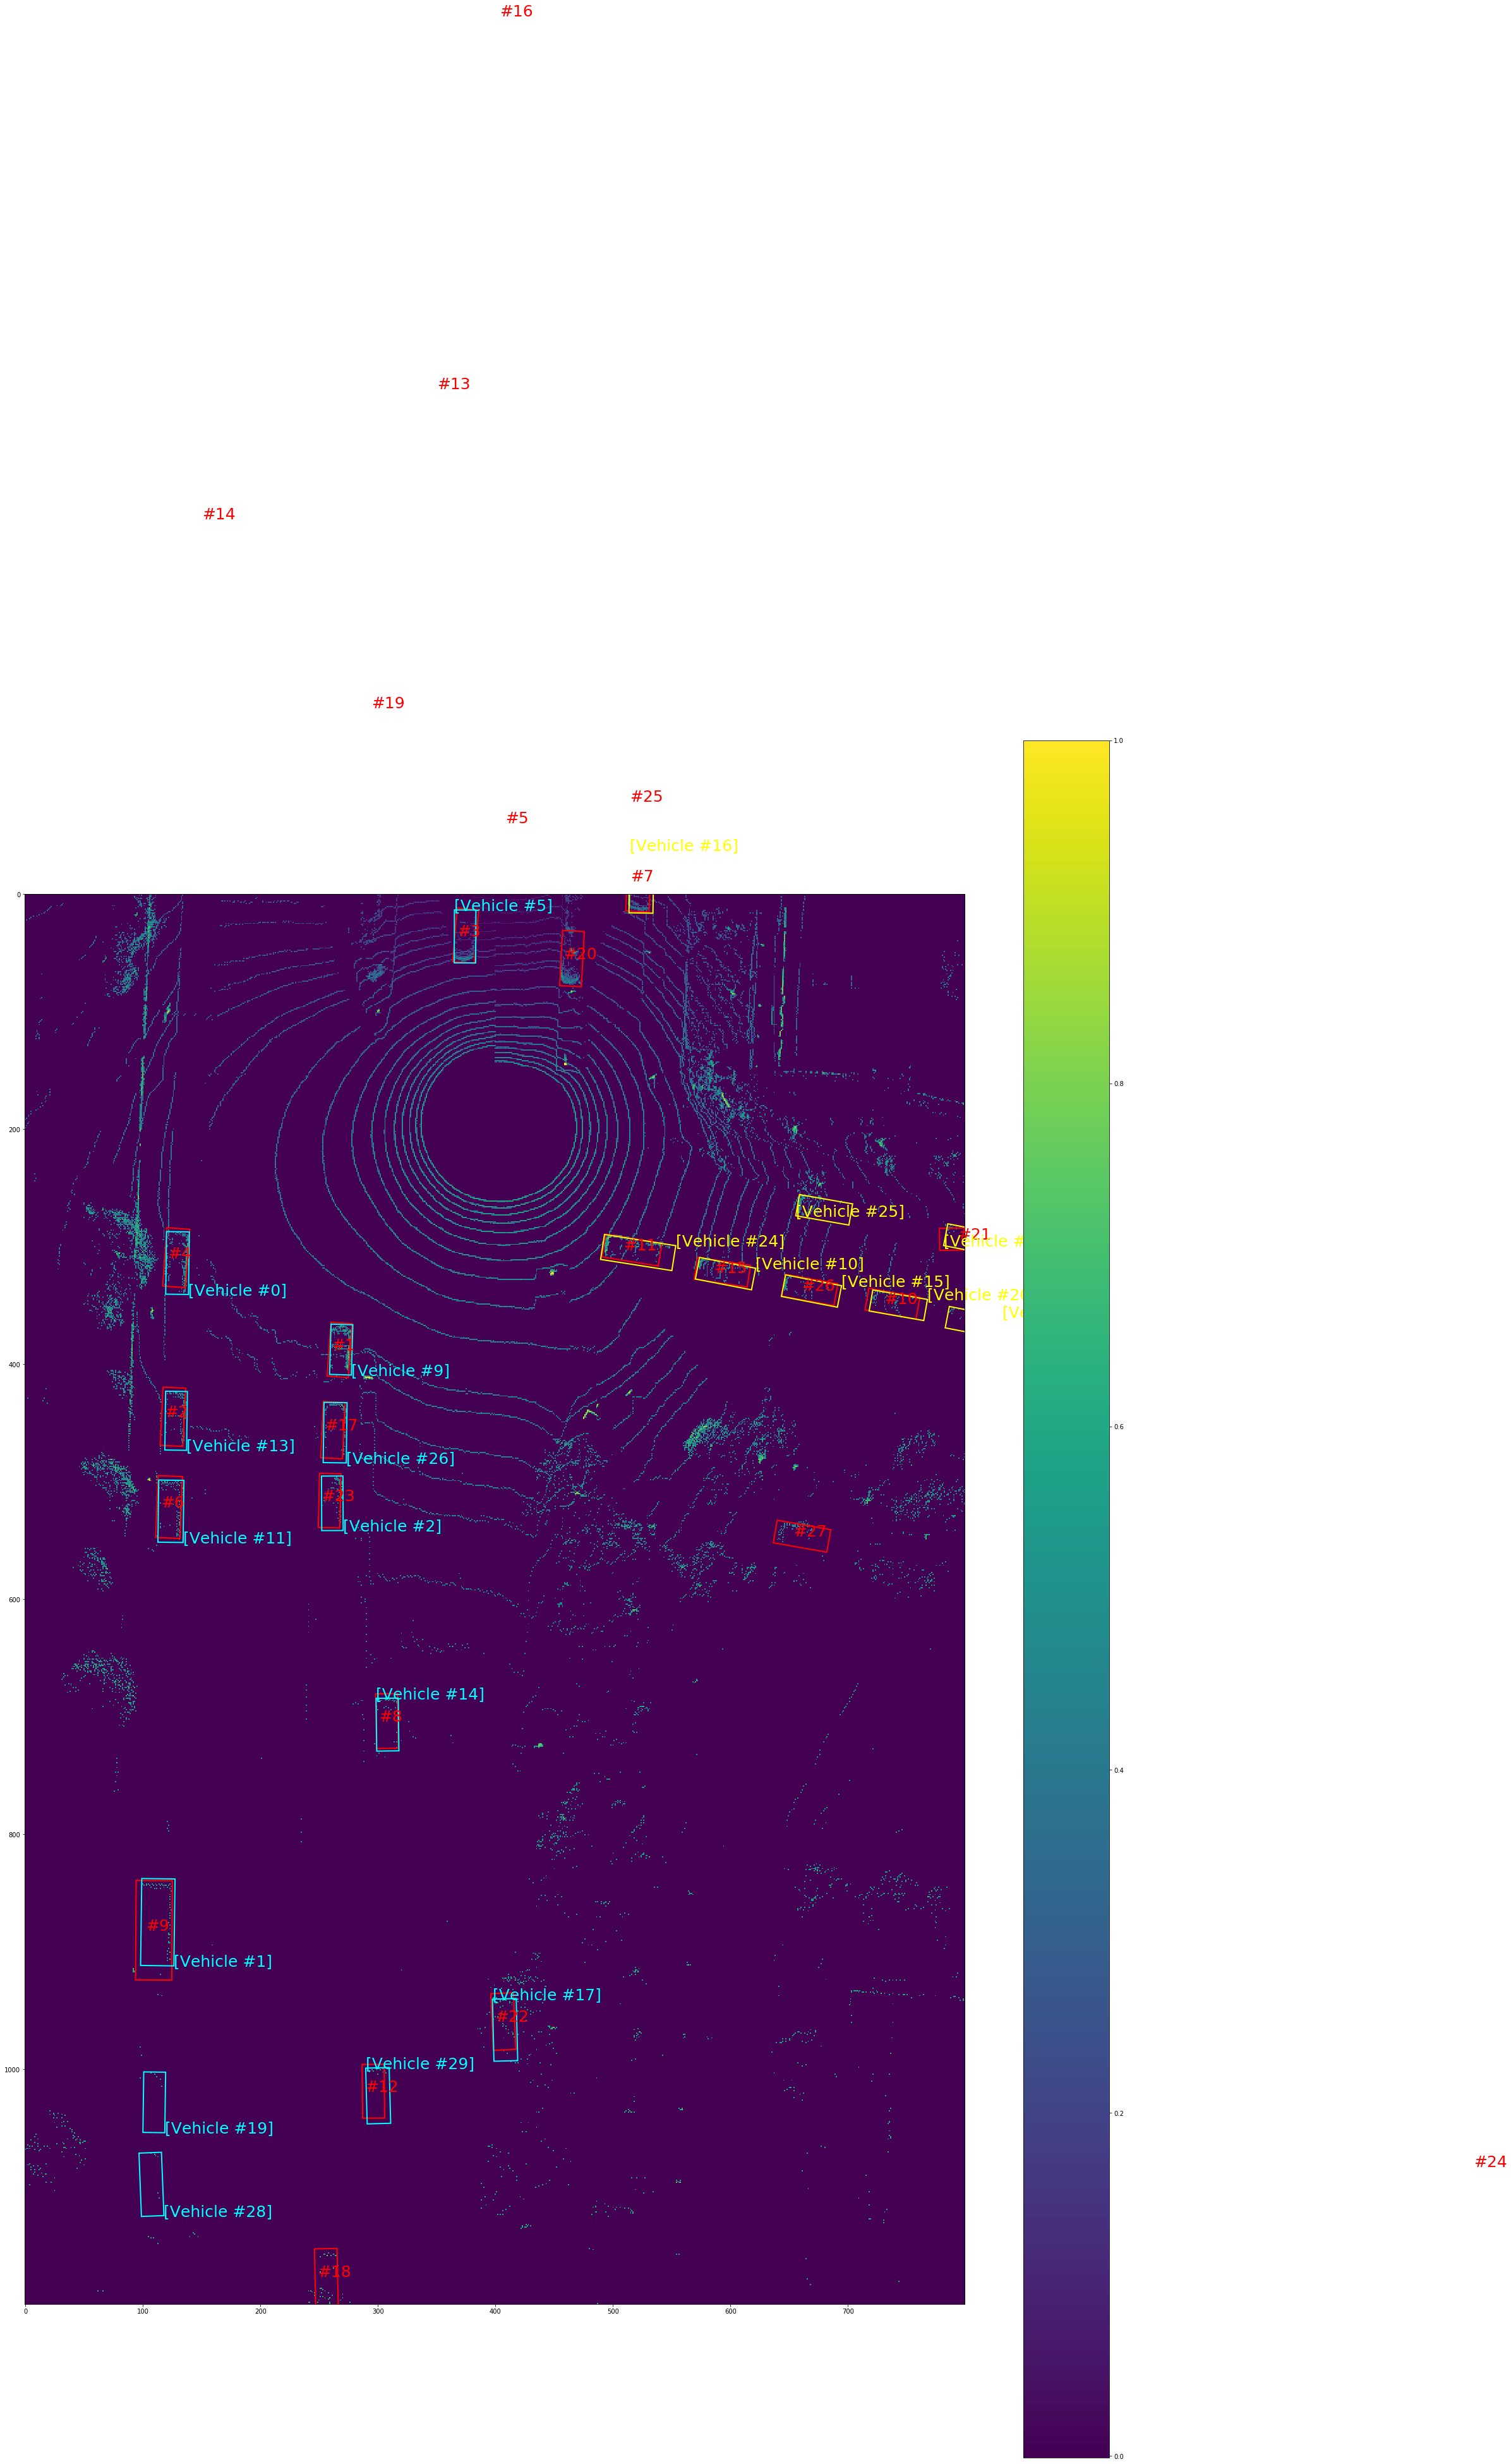

In [10]:
#plot result
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
fig_size = 50

fig = plt.figure(1,figsize=(fig_size/res_ratio,fig_size))
ax = fig.add_subplot(111)
plt.imshow(densityGridVals)
plt.colorbar()


index = 0
for hypothesis in detections:
    x_box_origin = hypothesis[0]-math.cos(hypothesis[4])*(hypothesis[2])/2-math.sin(hypothesis[4])*(hypothesis[3])/2
    y_box_origin = hypothesis[1]-math.cos(hypothesis[4])*(hypothesis[3])/2+math.sin(hypothesis[4])*(hypothesis[2])/2
   
    
    rect = patches.Rectangle((y_box_origin,x_box_origin),hypothesis[3],hypothesis[2],linewidth=2,edgecolor='r',facecolor='none',angle = math.degrees(hypothesis[4]))
    ax.add_patch(rect)
    index += 1

    ax.text(hypothesis[1]-0.7/dy,hypothesis[0], '#'+str(index), fontsize=25,color = 'red')

    
index = 0
for ground_truth in ground_truth_grid_anchor:
    if gt_is_visible[index] == 1: 
        x_box_origin = ground_truth[0]-math.cos(ground_truth[4])*(ground_truth[2])/2-math.sin(ground_truth[4])*(ground_truth[3])/2
        y_box_origin = ground_truth[1]-math.cos(ground_truth[4])*(ground_truth[3])/2+math.sin(ground_truth[4])*(ground_truth[2])/2
     
        
        #gt_box_label = 'Vehicle #'+str(index)+'\nIoU: '+str(hypothesis_IoU[index])
        gt_box_label = '[Vehicle #'+str(index)+']'
        gt_box_color = 'cyan'
        
        if(should_recognize[index] == 0):
            #gt_box_label = '[Vehicle #'+str(index)+'\nIoU: '+str(hypothesis_IoU[index])+']'
            gt_box_label = '[Vehicle #'+str(index)+']'
            gt_box_color = 'yellow'

        rect = patches.Rectangle((y_box_origin,x_box_origin),ground_truth[3],ground_truth[2],linewidth=2,edgecolor=gt_box_color,facecolor='none',angle = math.degrees(ground_truth[4]))
        ax.text(y_box_origin,x_box_origin, gt_box_label, fontsize=25,color = gt_box_color)
        ax.add_patch(rect)

    
    index += 1


plt.show()